# Inpainting with ControlNet
This notebook contains examples of using a new `StableDiffusionControlNetInpaintPipeline`.

The main two parameters you can play with are the strength of text guidance and image guidance:
* Text guidance (`guidance_scale`) is set to `7.5` by default, and usually this value works quite well.
* Image guidance (`controlnet_conditioning_scale`) is set to `0.4` by default. This value is a good starting point, but can be lowered if there is a big misalignment between the text prompt and the control image (meaning that it is very hard to "imagine" an output image that both satisfies the text prompt and aligns with the control image).

The naming of these parameters is based on other pipelines `StableDiffusionInpaintPipeline` and `StableDiffusionControlNetPipeline` and the same convention has been preserved for consistency.

In [1]:
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from src.pipeline_controlnet_inpaint import *
from diffusers.utils import load_image

import cv2
from PIL import Image
import numpy as np
import torch
from matplotlib import pyplot as plt

/home/perple/anaconda3/envs/animateAnyone/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Baseline: Stable Diffusion 1.5 Inpainting
The StableDiffusion1.5 Inpainting model is used as the core for ControlNet inpainting. For reference, you can also try to run the same results on this core model alone:

In [2]:
pipe_sd = StableDiffusionInpaintPipeline.from_pretrained(
    "../ckpts/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
# speed up diffusion process with faster scheduler and memory optimization
pipe_sd.scheduler = UniPCMultistepScheduler.from_config(pipe_sd.scheduler.config)
# remove following line if xformers is not installed
pipe_sd.enable_xformers_memory_efficient_attention()

pipe_sd.to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "../ckpts/stable-diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Task
Let's start by turning this dog into a red panda using various types of guidance!

All we need is an `image`, a `mask`, and a `text_prompt` of **"a red panda sitting on a bench"**

Text(0.5, 1.0, 'Masked')

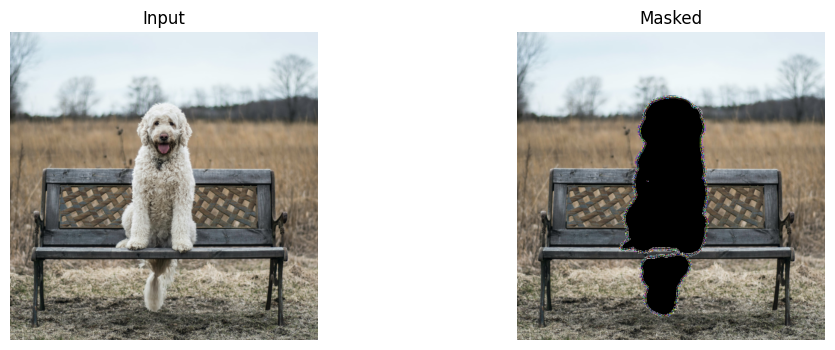

In [3]:
# download an image
image = load_image(
     "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
)
image = np.array(image)
mask_image = load_image(
     "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
)
mask_image = np.array(mask_image)

text_prompt="a red panda sitting on a bench"

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')

## Canny Edge

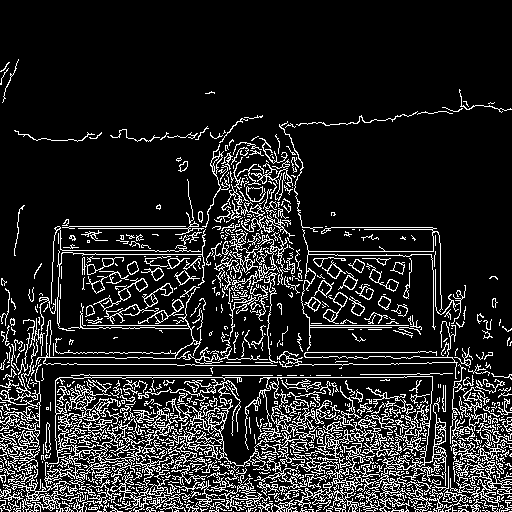

In [4]:
# get canny image
canny_image = cv2.Canny(image, 100, 200)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)

image=Image.fromarray(image)
mask_image=Image.fromarray(mask_image)
canny_image = Image.fromarray(canny_image)

canny_image

In [5]:
# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("../ckpts/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "../ckpts/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


### Scaling image control...
In this example, `canny_image` input is actually quite hard to satisfy with the our text prompt due to a lot of local noise. In this special case, we adjust `controlnet_conditioning_scale` to `0.5` to make this guidance more subtle.

In all other examples, the default value of `controlnet_conditioning_scale` = `1.0` works rather well!

In [6]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=canny_image,
    controlnet_conditioning_scale = 0.5,
    mask_image=mask_image
).images[0]

new_image.save('output/canny_result.png')

/home/perple/anaconda3/envs/animateAnyone/lib/python3.10/site-packages/diffusers/pipelines/controlnet/pipeline_controlnet.py:280: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 20/20 [00:01<00:00, 10.71it/s]
/home/perple/anaconda3/envs/animateAnyone/lib/python3.10/site-packages/diffusers/pipelines/controlnet/pipeline_controlnet.py:513: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


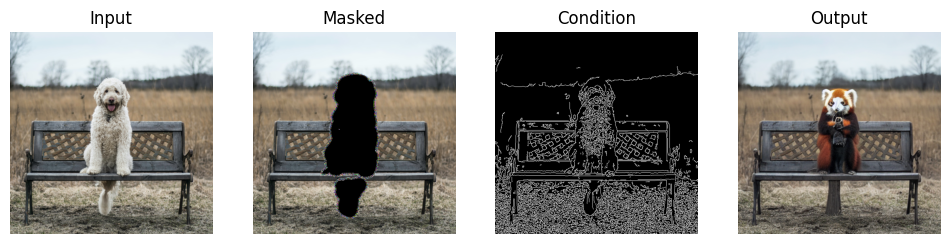

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(canny_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/canny_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### Comparison: vanilla inpainting from StableDiffusion1.5

In [8]:
# generate image
generator = torch.manual_seed(0)
new_image = pipe_sd(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    mask_image=mask_image
).images[0]

new_image.save('output/baseline_result.png')

100%|██████████| 20/20 [00:01<00:00, 19.64it/s]


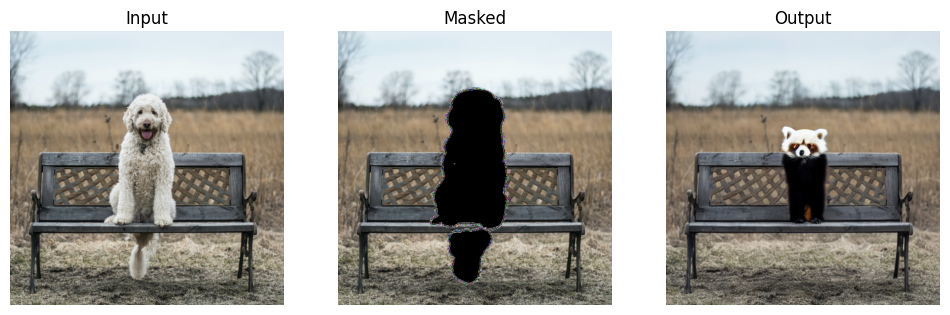

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,3,3)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/baseline_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

## Challenging Examples 🐕➡️🍔
Let's see how tuning the `controlnet_conditioning_scale` works out for a more challenging example of turning the dog into a cheeseburger!

In this case, we **demand a large semantic leap** and that requires a more subtle guide from the control image!

In [10]:
difficult_text_prompt="a big cheeseburger sitting on a bench"

100%|██████████| 20/20 [00:01<00:00, 19.37it/s]


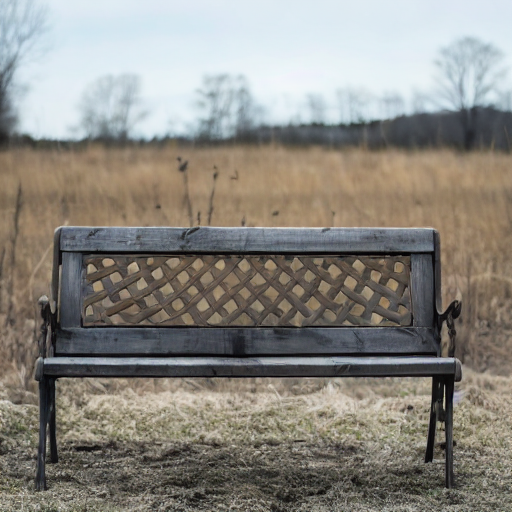

In [11]:
# First - StableDiffusion1.5 baseline (no ControlNet)

# generate image
generator = torch.manual_seed(0)
new_image = pipe_sd(
    difficult_text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    mask_image=mask_image
).images[0]

sd_output=new_image
sd_output

### Depth

In [12]:
from transformers import pipeline

depth_estimator = pipeline('depth-estimation')

depth_image = depth_estimator(image)['depth']
depth_image = np.array(depth_image)
depth_image = depth_image[:, :, None]
depth_image = np.concatenate(3*[depth_image], axis=2)
depth_image = Image.fromarray(depth_image)

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [13]:
# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("../ckpts/sd-controlnet-depth", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "../ckpts/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


In [14]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=depth_image,
    mask_image=mask_image
).images[0]

new_image.save('output/depth_result.png')

/home/perple/anaconda3/envs/animateAnyone/lib/python3.10/site-packages/diffusers/pipelines/controlnet/pipeline_controlnet.py:280: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 20/20 [00:01<00:00, 14.08it/s]
/home/perple/anaconda3/envs/animateAnyone/lib/python3.10/site-packages/diffusers/pipelines/controlnet/pipeline_controlnet.py:513: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


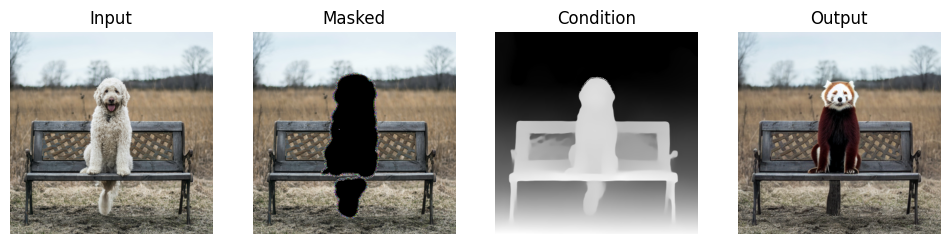

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(depth_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/depth_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### Normal Map

In [16]:
import cv2

depth_estimator = pipeline("depth-estimation", model ="Intel/dpt-hybrid-midas" )

normal_image = depth_estimator(image)['predicted_depth'][0]

normal_image = normal_image.numpy()

image_depth = normal_image.copy()
image_depth -= np.min(image_depth)
image_depth /= np.max(image_depth)

bg_threhold = 0.4

x = cv2.Sobel(normal_image, cv2.CV_32F, 1, 0, ksize=3)
x[image_depth < bg_threhold] = 0

y = cv2.Sobel(normal_image, cv2.CV_32F, 0, 1, ksize=3)
y[image_depth < bg_threhold] = 0

z = np.ones_like(x) * np.pi * 2.0

normal_image = np.stack([x, y, z], axis=2)
normal_image /= np.sum(normal_image ** 2.0, axis=2, keepdims=True) ** 0.5
normal_image = (normal_image * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
normal_image = Image.fromarray(normal_image).resize((512,512))

config.json: 100%|██████████| 9.88k/9.88k [00:00<00:00, 22.7MB/s]
pytorch_model.bin: 100%|██████████| 490M/490M [03:39<00:00, 2.23MB/s] 
preprocessor_config.json: 100%|██████████| 382/382 [00:00<00:00, 579kB/s]


: 

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-normal", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=normal_image,
    mask_image=mask_image
).images[0]

new_image.save('output/normal_result.png')

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(normal_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/normal_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### More control input types
For these control input types, we will use a different image as in those cases, an image of the dog on the bench is not appropriate!

Let's start with a room photo...

### OpenPose

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
from controlnet_aux import OpenposeDetector

openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

pose_real_image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-openpose/resolve/main/images/pose.png")

pose_image = openpose(pose_real_image)
pose_real_image=pose_real_image.resize(pose_image.size)

pose_mask=np.zeros_like(np.array(pose_image))
pose_mask[250:700,:,:]=255
pose_mask=Image.fromarray(pose_mask)

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "a man in a knight armor",
    num_inference_steps=20,
    generator=generator,
    image=pose_real_image,
    control_image=pose_image,
    mask_image=pose_mask
).images[0]

new_image.save('output/openpose_result.png')

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(pose_real_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(pose_real_image))*(255-np.array(pose_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(pose_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')


plt.savefig('output/openpose_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### Segmentation Mask

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-seg", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
house_real_image=load_image("https://huggingface.co/lllyasviel/sd-controlnet-seg/resolve/main/images/house.png")
seg_image=load_image("https://huggingface.co/lllyasviel/sd-controlnet-seg/resolve/main/images/house_seg.png")

house_mask=np.zeros((*seg_image.size,3),dtype='uint8')
house_mask[50:400,-350:,:]=255
house_mask=Image.fromarray(house_mask)

In [ ]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "a pink eerie scary house",
    num_inference_steps=20,
    generator=generator,
    image=house_real_image,
    control_image=seg_image,
    mask_image=house_mask
).images[0]

new_image.save('output/seg_result.png')

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(house_real_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(house_real_image))*(255-np.array(house_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(seg_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/seg_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )